# Models

In [1]:
# import required modules
import warnings
warnings.filterwarnings('ignore')

import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import pearsonr
from scipy.stats import ttest_1samp
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

import seaborn.apionly as sns
sns.set_context("poster")
from IPython.display import display
matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
# we define a function to calculate the Concordance Correlation Coefficient (a measure to evaluate our models)
def ccc_function(y,y_hat):
    pcc, _ = pearsonr(y_hat,y)
    ccc = 2 * pcc * y.std() * y_hat.std()/(y.var() + y_hat.var() + (y.mean() - y_hat.mean())**2)
    return ccc

In [3]:
# function to evaluate our quantitative models and store the result in a summary dictionary
def evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary):
    # input:
    # y_train,y_hat_train,y_test,y_hat_test
    # summary: dictionary with fields model name, R2train, R2test, PCC and CCC
    pcc, _ = pearsonr(y_test,y_hat_test)
    ccc = ccc_function(y_test,y_hat_test)
    r2train = r2_score(y_train,y_hat_train)
    r2test = r2_score(y_test,y_hat_test)
    summary['model name'].append(name)
    summary['R2train'].append(r2train)
    summary['R2test'].append(r2test)
    summary['PCC'].append(pcc)
    summary['CCC'].append(ccc)
    return r2train,r2test,pcc,ccc,summary

# set up a summary dictionary
summary = {'model name':[],'R2train':[],'R2test':[],"PCC":[],'CCC':[]}


## Baseline Model: Simple Linear Regression


Our first step is to clean up the demographic variables and split our data into training and test sets. We group all the predictors (demographic + MRI imaging) together and extract 2 outcome variables: 1.) the MMSE score which we want to predict, and 2.) the diagnosis which we will use to evaluate the usefulness of our MMSE prediction in the last part.  
We first try a simple linear regression model with all predictors and MMSE as the outcome.

In [4]:
with open('mmse_data1.pickle', 'rb') as f:
    (X_train,X_test,y_train,y_test,y_dx_train,y_dx_test,summary) = pickle.load(f)

In [5]:

# try a super-simple linear regression model on all predictors
simple_est = LinearRegression(fit_intercept = True)
simple_est.fit(X_train,y_train)
y_hat_train = simple_est.predict(X_train)
y_hat_test = simple_est.predict(X_test)

name = 'Linear regression with all predictors'
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

Linear regression with all predictors : 
R2 score on training set:  1.0
R2 score on validation set:  -0.575703582103
Pearson's correlation coefficient between estimate and ground truth(test set) 0.292637073937
Concordance correlation coefficient between estimate and ground truth(test set) 0.29124810158


Because of the large number of predictors and the multi-colinearity of the predictors, the model with all predictors suffers from high variance which is characterized by a large discrepancy between performances on the training and test sets. Overall, variance appears to be the biggest problem in predicting this dataset. We will use principal component analysis, stepwise feature selection and ensemble strategies to reduce the dimensionality and eliminate colinearity. In addition, we will try regularization to further reduce variance problems.

## Principal Component Analysis and Regularized Linear Regression
  
    
    
First, we reduce the dimensionality by principal component analysis and keep enough principal components that capture 90% of the variance in the data. 

In [6]:
# PCA transformation with PCs that account for 90% of variance in training set
fullpca = PCA(n_components = 0.9,svd_solver = 'full')
X_train_pca = fullpca.fit_transform(X_train)
X_test_pca = fullpca.transform(X_test)
total_pcs = X_train_pca.shape[1]
print("Number of PCs accounting for 90% of variance: ", total_pcs)

Number of PCs accounting for 90% of variance:  197


We still have 197 components/predictors left after principal component analysis. Let's try a simple linear regression model on these:

In [7]:
# try a simple linear regression model without regularization on all 197 PCs
pca_lin_est = LinearRegression(fit_intercept = True)
pca_lin_est.fit(X_train_pca,y_train)
y_hat_train = pca_lin_est.predict(X_train_pca)
y_hat_test = pca_lin_est.predict(X_test_pca)

name = 'Linear regression on {} PCs'.format(total_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

Linear regression on 197 PCs : 
R2 score on training set:  0.607144507434
R2 score on validation set:  0.146129866785
Pearson's correlation coefficient between estimate and ground truth(test set) 0.462698583976
Concordance correlation coefficient between estimate and ground truth(test set) 0.434770218566


While our test set performance has improved, we still have a relatively high discrepancy between performance on the training and test set which is indicative of variance problems. Even though we have eliminated co-linearity between predictors through PCA, this does not mean that each of our predictors is correlated with our outcome variable MMSE. We will try different types of regularization to reduce variance and improve our bias/variance trade-off.  
We first try ridge regularization with cross-validation to identify the ideal regularization strength hyper-parameter, then train on the whole training set with the optimal parameter.

In [8]:
# try ridge regularization
alphas = [100000,50000,10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01]

ridge_pca_est = RidgeCV(alphas=alphas,fit_intercept = True,cv=5)
ridge_pca_est.fit(X_train_pca,y_train)
best_alpha = ridge_pca_est.alpha_

# now train on whole training set with best alpha
ridge_pca_est = Ridge(alpha=best_alpha,fit_intercept = True)
ridge_pca_est.fit(X_train_pca,y_train)
y_hat_train = ridge_pca_est.predict(X_train_pca)
y_hat_test = ridge_pca_est.predict(X_test_pca)

name = 'Ridge regression with {} PCs'.format(total_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('Regularization parameter: ', best_alpha)
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

Ridge regression with 197 PCs : 
Regularization parameter:  5000
R2 score on training set:  0.471061556011
R2 score on validation set:  0.265014380849
Pearson's correlation coefficient between estimate and ground truth(test set) 0.518424013095
Concordance correlation coefficient between estimate and ground truth(test set) 0.419587774173


This has improved our R2 score on the test set quite dramatically. We try another type of regularization, Elastic Net regularization. This method combines L1 (Lasso) and L2 (Ridge) regularization. We cross-validate for regularization strength and the ratio between L1 and L2.

In [9]:
# elastic net regularization
ratios = [.001,.01,.1, .5, .7, .9, .95, .99, 1]
elnet_est = ElasticNetCV(l1_ratio = ratios, alphas=alphas,fit_intercept = True,cv=5)
elnet_est.fit(X_train_pca,y_train)
best_alpha = elnet_est.alpha_
best_ratio = elnet_est.l1_ratio_

elnet_est = ElasticNet(l1_ratio = best_ratio, alpha=best_alpha,fit_intercept = True)
elnet_est.fit(X_train_pca,y_train)
y_hat_train = elnet_est.predict(X_train_pca)
y_hat_test = elnet_est.predict(X_test_pca)

name = 'Elastic Net regression with {} PCs'.format(total_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('Regularization parameter: ', best_alpha)
print('L1 ratio: ',best_ratio)
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

Elastic Net regression with 197 PCs : 
Regularization parameter:  10.0
L1 ratio:  0.01
R2 score on training set:  0.430632422622
R2 score on validation set:  0.267113344982
Pearson's correlation coefficient between estimate and ground truth(test set) 0.52064312814
Concordance correlation coefficient between estimate and ground truth(test set) 0.41525211834


The Elastic Net regularization has not improved our model compared to ridge regularization. Moreover, the optimal ratio between L1 and L2 regularization  is very close to pure L2 regularization, further confirming ridge regularization as the optimal decision in this scenario.

As an alternative to regularization, we try to determine the optimal number of PCs to include in a simple linear regression model.


Optimal number of principal components:  20
linear regression with 20 PCs : 
R2 score on training set:  0.321961145795
R2 score on validation set:  0.226915996482
Pearson's correlation coefficient between estimate and ground truth(test set) 0.486073194638
Concordance correlation coefficient between estimate and ground truth(test set) 0.41508971522


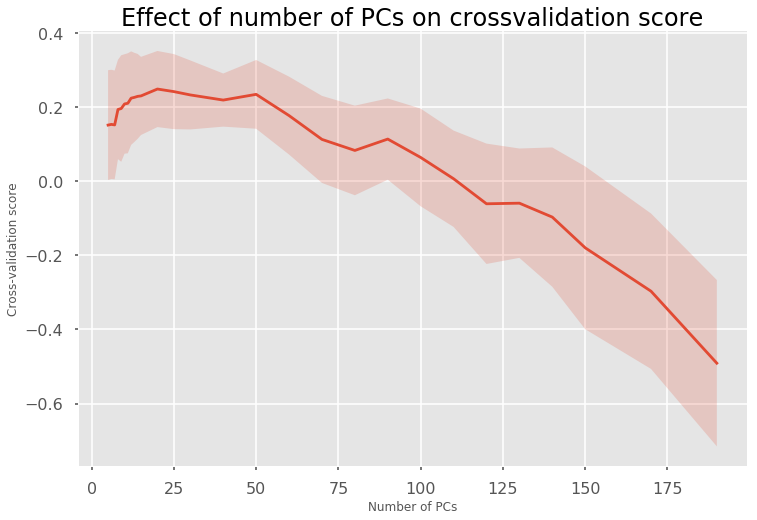

In [10]:
# find optimal number of PCs to include in model by determining the 5fold crossvalidation r2 score 
# in a linear regression model 
scorelist = []

#pcs = range(1,total_pcs+1)
pcs = [5,6,7,8,9,10,11,12,13,14,15,20,25,30,40,50,60,70,80,90,100,110,120,130,140,150,170,190]
for use_pcs in pcs:
    scores = cross_val_score(pca_lin_est,X_train_pca[:,:use_pcs],y_train,cv=5)
    scorelist.append(scores)
    
#plot crossvalidation score means and std as a function of number of PCs
score_array = np.vstack(scorelist)    
valid_means = score_array.mean(axis=1)
valid_stds = score_array.std(axis=1)

fig4 = plt.figure(figsize = [12,8])
plt.title('Effect of number of PCs on crossvalidation score', fontsize = 24)
ax = plt.gca()
plt.plot(pcs,valid_means)
ax.fill_between(pcs,valid_means+valid_stds,valid_means-valid_stds,alpha = 0.2)
ax.set_ylabel('Cross-validation score')
ax.set_xlabel('Number of PCs')
sns.despine()

# determine optimal number of PCs based on crossvalidation score and fit a linear regression model
optimal_pcs = pcs[np.argmax(valid_means)]
print("\nOptimal number of principal components: ",optimal_pcs)


# fit to complete training set with best set of predictors (PCs)
pca_lin_est.fit(X_train_pca[:,:optimal_pcs],y_train)

# get stats
y_hat_train = pca_lin_est.predict(X_train_pca[:,:optimal_pcs])
y_hat_test = pca_lin_est.predict(X_test_pca[:,:optimal_pcs])

name = 'linear regression with {} PCs'.format(optimal_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

Based on our cross-validation results, including the first 20 principal components yields the best test R2 score. Adding more principal components to the model leads to higher variance. This is also illustrated in the figure above. The test R2 score of this unregularized model with 20 PCs is comparable to the Ridge regression model on all 197 PCs. Further regularization does not improve this model (data not shown).

## Step-wise feature selection based on cross-validation score
  
    
In lieu of PCA, we also try dimensionality reduction by step-wise feature selection. We first split our training set into a smaller training set to stepwise select predictors and a validation set to select the number of predictors to keep. We use a simple linear regression model without regularization for this purpose.

In [11]:
# we split off another validation set to choose the number of features 
X_train_sm, X_valid,y_train_sm,y_valid = train_test_split(X_train,y_train,test_size= 150,random_state = 7)

# now we select predictors stepwise by crossvalidation
all_predictors = X_train.columns.values
predictors = []

# add predictors step-wise
max_predictors = 30 
for k in range(1, max_predictors):
    
    if k == 1:
        used_predictors = []
    else:
        used_predictors = predictors[-1]
    
    # get currently unused predictors
    unused_predictors = list(set(all_predictors) - set(used_predictors))
    
    # add each of the unused predictors one at a time and store the mean of cross-validation scores
    xvalscores = []
    for predictor in unused_predictors:
        # cross validate with chosen predictors on small training set
        k_predictors = used_predictors + [predictor]
        X_train_k = X_train_sm[k_predictors]
        linreg_est = LinearRegression(fit_intercept = True)
        kf = KFold(n_splits=3, shuffle=True, random_state=7)
        score = cross_val_score(linreg_est,X_train_k,y_train_sm,cv=kf).mean()
        xvalscores.append(score)
    
    # then choose the predictor that gives the best cross-validation score and add it to the list of used predictors
    best_k = used_predictors + [unused_predictors[np.argmax(xvalscores)]]
    predictors.append(best_k)

linear regression with 5 predictors : 
optimal number of predictors:  5
predictors:  ['FreeSurfer.thickness..mean.1009', 'FreeSurfer.thickness..mean.2006', 'mean.curvature..kurtosis.1007', 'geodesic.depth..SD.1011', 'PTEDUCAT']
R2 score on training set:  0.347888052415
R2 score on validation set:  0.263384791347
Pearson's correlation coefficient between estimate and ground truth(test set) 0.522998265342
Concordance correlation coefficient between estimate and ground truth(test set) 0.457283947517


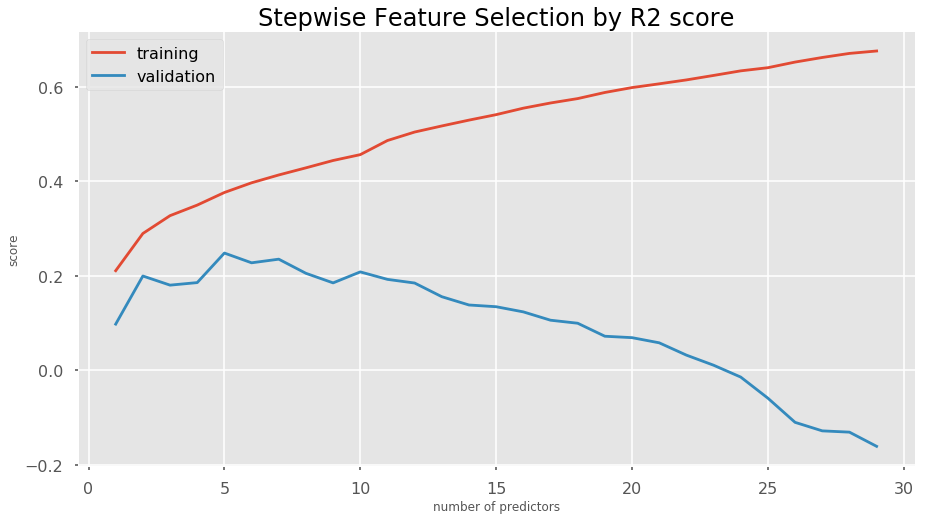

In [12]:
# we now choose the number of predictors based on the R2 score on the held-out validation set
train_scores = []
valid_scores = []
# loop through sets of predictors
for p in predictors:
    #fit a linear regression model with chosen set of predictors on small training set
    linreg_est.fit(X_train_sm[p],y_train_sm)
    
    # get R2 score for small training set and validation set
    y_hat_train_sm = linreg_est.predict(X_train_sm[p])
    y_hat_valid = linreg_est.predict(X_valid[p])
    
    train_scores.append(r2_score(y_train_sm,y_hat_train_sm))
    valid_scores.append(r2_score(y_valid,y_hat_valid))

# plot train and validation set scores as a function of number of predictors
fig5 = plt.figure(figsize= [15,8])
plt.plot(range(1, max_predictors),train_scores)
plt.plot(range(1, max_predictors),valid_scores)
plt.title('Stepwise Feature Selection by R2 score',fontsize=24)
plt.xlabel('number of predictors')
plt.ylabel('score')
plt.legend(['training','validation'])

# choose the model with the best test score
best_predictors = predictors[np.argmax(valid_scores)]

# extract best predictors to new dataframe
X_train_feat = X_train[best_predictors]
X_test_feat = X_test[best_predictors]

# fit linear regression model to complete (not small) training set and evaluate on training and test set
linreg_est = LinearRegression()
linreg_est.fit(X_train_feat,y_train)
y_hat_train = linreg_est.predict(X_train_feat)
y_hat_test = linreg_est.predict(X_test_feat)

name = 'linear regression with {} predictors'.format(len(best_predictors))
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('optimal number of predictors: ',len(best_predictors))
print('predictors: ',best_predictors)
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

The graph shows that the bias/variance trade-off is optimal for a model with 5 predictors where the R2 score on the validation set is highest. Fewer predictors lead to higher bias, more predictors to higher variance. This simple linear regression model with only 5 predictors and no regularization achieves a similar performance as the PCA models. We next check if regularization (Ridge Regularization with Cross-validation) improves this model further.  
We also identified 5 predictors that are helpful in predicting the mental state. Of these PTEDUCAT is a demographic confounding variable that affects the MMSE but not the dementia or AD diagnosis. The other 4 features, however, are all anatomical features from brain imaging and are prime candidates to use in the diagnosis of AD in the future. 

In [13]:
# test if regularization improves the model
ridge_feat_est = RidgeCV(alphas=alphas,fit_intercept = True,cv=5)
ridge_feat_est.fit(X_train_feat,y_train)
best_alpha = ridge_feat_est.alpha_

# now train on whole training set with best alpha
ridge_feat_est.fit(X_train_feat,y_train)
y_hat_train = ridge_feat_est.predict(X_train_feat)
y_hat_test = ridge_feat_est.predict(X_test_feat)

name = 'linear regression model with Ridge regularization on {} PCA predictors'.format(total_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print("Regularization parameter for Ridge regularization: ",best_alpha)
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)


linear regression model with Ridge regularization on 197 PCA predictors : 
Regularization parameter for Ridge regularization:  50
R2 score on training set:  0.346354646594
R2 score on validation set:  0.267638593243
Pearson's correlation coefficient between estimate and ground truth(test set) 0.522653783263
Concordance correlation coefficient between estimate and ground truth(test set) 0.441699871133


Regularization does not appear to improve the plain linear regression model further.

## Ensemble Methods
  
### Random Forest Regressor
  
   
Ensemble methods like Random Forest Regression or Gradient Boosting are another way to reduce the number of features being considered in the model. We first try Random Forest Regression and crossvalidate to optimize the maximum depth of the trees on a relatively small number of trees (64), we fix the number of features to the square root of all features (46). We then increase the number of trees to 512 to acchieve a slightly better model. Because of the long time it takes to compute these Random Forests we did not perform an exhaustive grid search of all hyper-parameters.

In [14]:
# because the random forest regression takes a long time to train , we just optimize for the tree depth
# we set the max_features to 'sqrt' and the number of trees to 64
# rf = RandomForestRegressor(n_estimators = 64,max_features = 'sqrt',random_state=7)
rf = RandomForestRegressor(n_estimators = 64,max_features = 'sqrt',random_state=7)

parameters = {'max_depth':[i for i in range(3,15)]}
gs_rf = GridSearchCV(rf,parameters)
gs_rf.fit(X_train,y_train)
print(gs_rf.best_estimator_)
print('optimal max_depth: ',gs_rf.best_estimator_.max_depth)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=1,
           oob_score=False, random_state=7, verbose=0, warm_start=False)
optimal max_depth:  6


In [15]:
# we then increase the number of trees to improve our model
rf_est = RandomForestRegressor(n_estimators = 512,max_features = 'sqrt',max_depth = 7)
rf_est.fit(X_train,y_train)
y_hat_train = rf_est.predict(X_train)
y_hat_test = rf_est.predict(X_test)

name = 'Random Forest Regressor with all predictors'
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)


Random Forest Regressor with all predictors : 
R2 score on training set:  0.795066847672
R2 score on validation set:  0.236115394044
Pearson's correlation coefficient between estimate and ground truth(test set) 0.491611693098
Concordance correlation coefficient between estimate and ground truth(test set) 0.350110313699


At least for the limited set of hyper-parameters we tested, the random forest model does not perform as well as our previous models.

### Gradient Boosting Regressor
  
We then tried a Gradient Boosting Regressor for our prediction using crossvalidation to determine the optimal depth of the individual estimators as well as the number of estimators. We then retrain on the complete training set and acchieve the best model performance so far:

In [16]:
# try Gradient Boosting
gbr = GradientBoostingRegressor()
parameters = {'max_depth':[i for i in range(1,5)],'n_estimators':[i*50 for i in range(1,4)]}
gs_gbr = GridSearchCV(gbr,parameters)
gs_gbr.fit(X_train,y_train)
print(gs_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [17]:
# retrain on the complete training set with optimal parameters
gbr_est = GradientBoostingRegressor(max_depth=4,n_estimators=100)
gbr_est.fit(X_train,y_train)

y_hat_train = gbr_est.predict(X_train)
y_hat_test = gbr_est.predict(X_test)


name = 'gradient boosting regressor with all predictors'
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)
#display(pd.DataFrame(np.array([name,r2train, r2test, pcc, ccc]).reshape(1,-1),columns=['model name','R2 train','R2 test',\
#                                                                "Pearson's Correlation Coefficient",\
#                                                               "Concordance Correlation Coefficient"]))

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)


gradient boosting regressor with all predictors : 
R2 score on training set:  0.996273889194
R2 score on validation set:  0.278239378459
Pearson's correlation coefficient between estimate and ground truth(test set) 0.528213158109
Concordance correlation coefficient between estimate and ground truth(test set) 0.447473718615
